# Block-Sparse Attention Demonstration

This notebook demonstrates:
1. Performance comparison: Dense vs Local vs Global vs Mixed attention
2. Attention pattern visualizations
3. Speed benchmarks across different sequence lengths

## Setup

In [1]:
!pip install pybind11 hf_transfer datasets matplotlib seaborn -q

In [2]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set project path - ADJUST THIS TO YOUR PATH
project_path = '/workspace/manav/dl_sys_project/'
os.chdir(project_path)

# Check GPU
print("Checking GPU availability...")
try:
    import subprocess
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT)
    print("✓ GPU Available")
except:
    print("✗ No GPU detected - will use CPU")

# Rebuild project
print("\nRebuilding project...")
# !make clean
!make

# Setup paths
sys.path.insert(0, os.path.join(project_path, 'python'))
sys.path.insert(0, os.path.join(project_path, 'apps'))

# Imports
import needle as ndl
import needle.nn as nn
from pythia_model import PythiaConfig, PythiaLM
from needle.nn.nn_sparse_attention import BlockSparsePattern

print(f"Needle backend: {ndl.backend_selection.BACKEND}")

# Set device
try:
    device = ndl.cuda()
    print("✓ Using CUDA (GPU)")
except Exception as e:
    print(f"CUDA not available: {e}")
    device = ndl.cpu()
    print("✓ Using CPU")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
np.random.seed(42)

Checking GPU availability...
✓ GPU Available

Rebuilding project...
-- Found pybind11: /usr/local/lib/python3.12/dist-packages/pybind11/include (found version "3.0.1")
-- Found cuda, building cuda backend
Thu Nov 27 04:40:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  |   00000000:0F:00.0 Off |                    0 |
| N/A   28C    P0          

## Load WikiText-2 Dataset

In [3]:
def load_wikitext_sample(max_tokens=10000, vocab_size=5000):
    """Load small sample from WikiText-2"""
    try:
        from datasets import load_dataset
        
        print("Loading WikiText-2...")
        dataset = load_dataset("wikitext", "wikitext-2-raw-v1")
        train_text = " ".join(dataset["train"]["text"][:500])  # First 100 documents
        
        # Tokenize
        tokens = train_text.lower().split()
        
        # Build vocabulary
        token_counts = Counter(tokens)
        special_tokens = ["<pad>", "<unk>"]
        max_vocab_tokens = vocab_size - len(special_tokens)
        most_common = token_counts.most_common(max_vocab_tokens)
        
        vocab = {token: idx for idx, token in enumerate(special_tokens)}
        for token, _ in most_common:
            if token not in vocab:
                vocab[token] = len(vocab)
        
        # Convert to indices
        unk_idx = vocab["<unk>"]
        data = np.array([vocab.get(token, unk_idx) for token in tokens[:max_tokens]])
        
        # Get sample sentence for visualization
        sample_sentence = train_text.split('.')[:3]  # First 3 sentences
        sample_sentence = '. '.join(sample_sentence).strip()
        sample_tokens = sample_sentence.lower().split()[:64]  # Limit to 64 tokens
        sample_indices = [vocab.get(token, unk_idx) for token in sample_tokens]
        
        print(f"Vocabulary size: {len(vocab)}")
        print(f"Total tokens: {len(data)}")
        print(f"Sample sentence ({len(sample_tokens)} tokens): {' '.join(sample_tokens[:20])}...")
        
        return data, len(vocab), sample_tokens, sample_indices
        
    except Exception as e:
        print(f"Error loading WikiText-2: {e}")
        print("Using synthetic data instead")
        data = np.random.randint(0, vocab_size, size=max_tokens)
        sample_tokens = [f"word{i}" for i in range(64)]
        sample_indices = list(range(64))
        return data, vocab_size, sample_tokens, sample_indices

# Load data
data, vocab_size, sample_tokens, sample_indices = load_wikitext_sample(max_tokens=10000, vocab_size=1000)

Loading WikiText-2...


Using the latest cached version of the dataset since wikitext couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'wikitext-2-raw-v1' at /workspace/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/0.0.0/b08601e04326c79dfdd32d625aee71d232d685c3 (last modified on Sat Nov 22 22:30:11 2025).


Vocabulary size: 1000
Total tokens: 10000
Sample sentence (54 tokens): = valkyria chronicles iii = senjō no valkyria 3 : unrecorded chronicles ( japanese : 戦場のヴァルキュリア3 , lit . valkyria...


## Attention Pattern Visualization

✓ Saved: attention_patterns.png


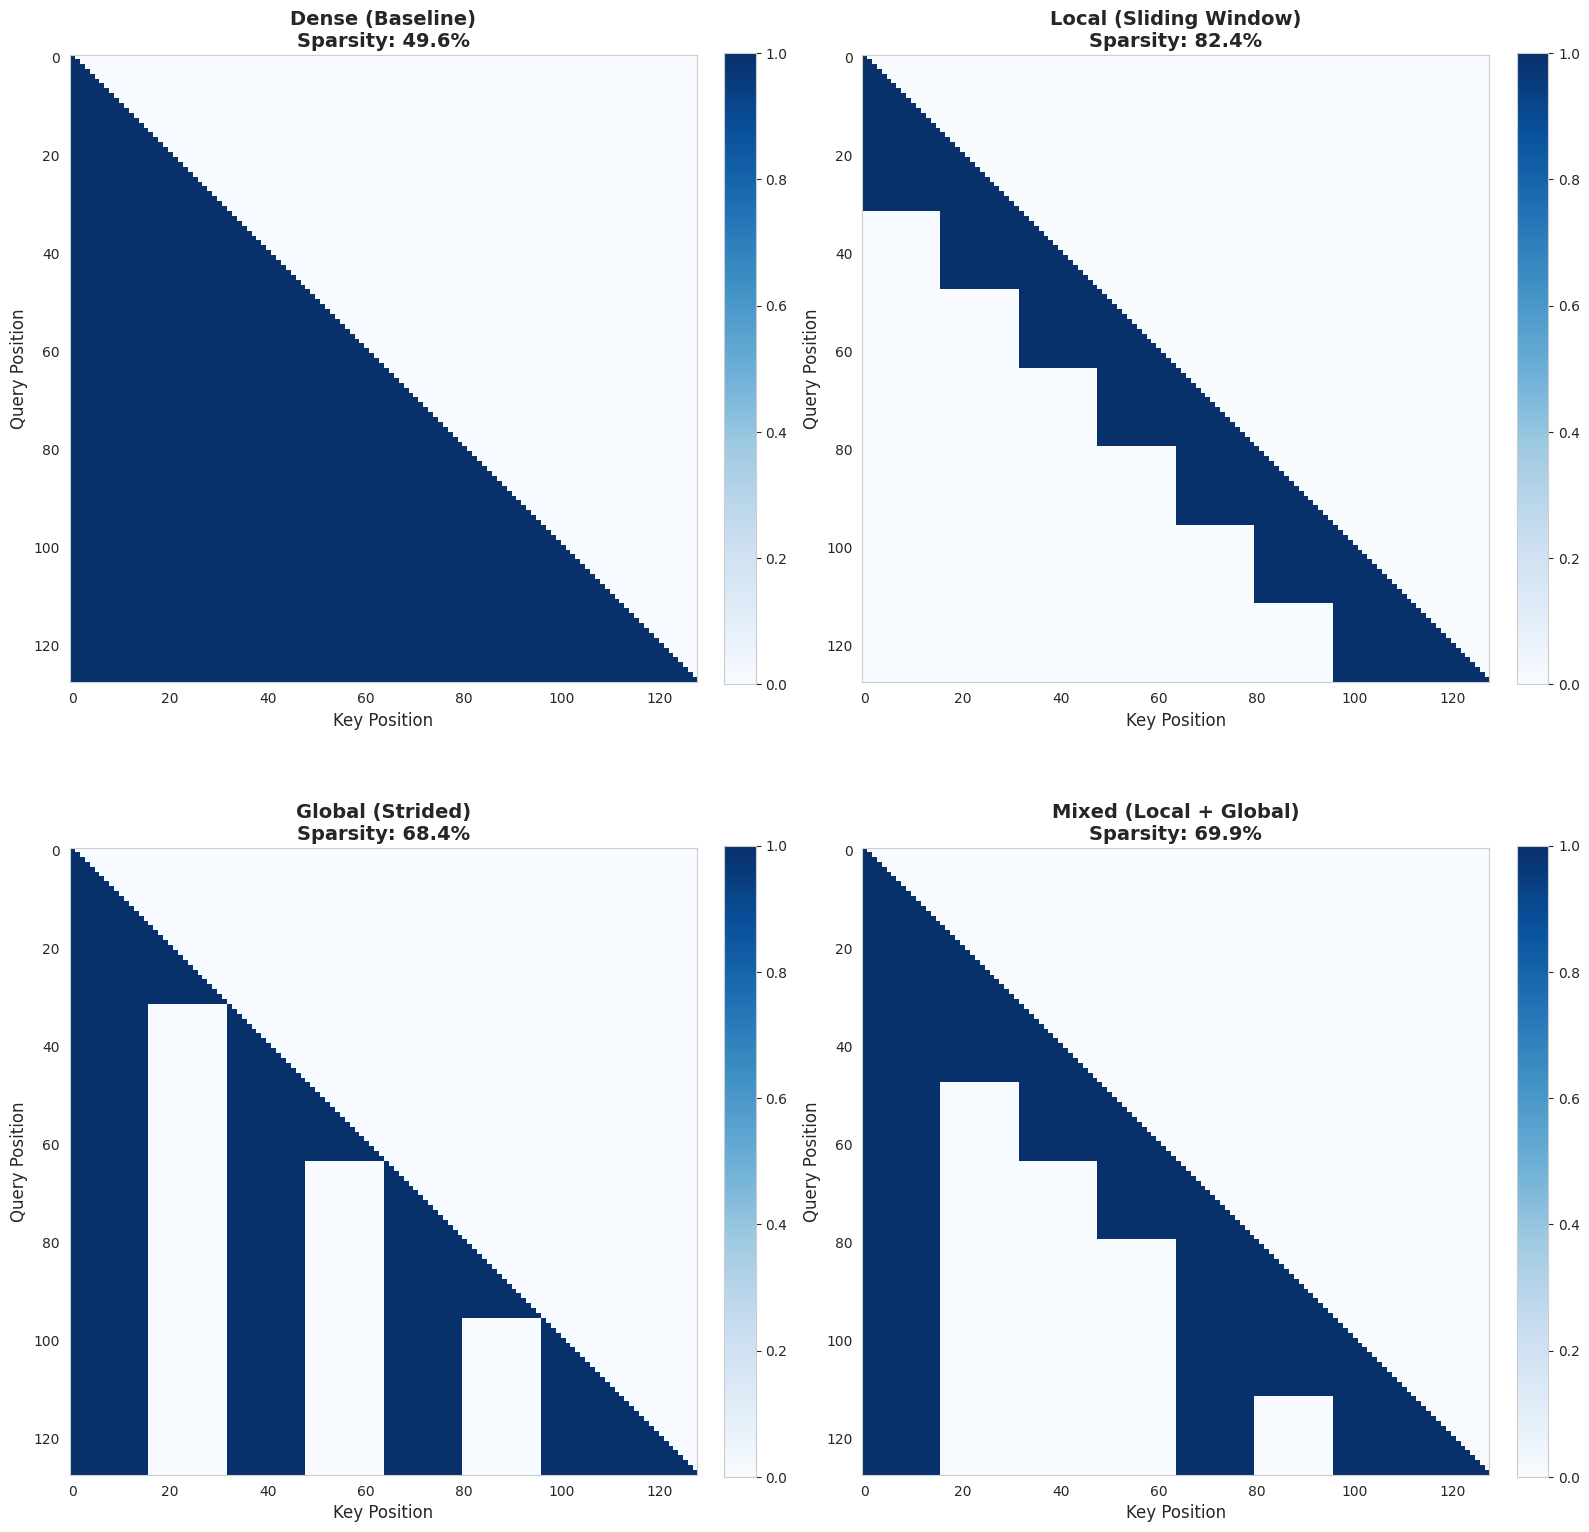

In [4]:
def visualize_attention_patterns():
    """Visualize different sparse attention patterns"""
    seq_len = 128
    block_size = 16
    
    # Generate patterns
    local_mask = BlockSparsePattern.local_pattern(seq_len, block_size, window_size=1)
    global_mask = BlockSparsePattern.global_pattern(seq_len, block_size, stride=2)
    mixed_mask = BlockSparsePattern.mixed_pattern(seq_len, block_size, window_size=1, stride=4)
    
    # Expand to full masks
    def expand_block_mask(block_mask, seq_len, block_size):
        n_blocks = block_mask.shape[0]
        full_mask = np.zeros((seq_len, seq_len))
        
        for i in range(n_blocks):
            for j in range(n_blocks):
                if block_mask[i, j]:
                    i_start = i * block_size
                    i_end = min((i + 1) * block_size, seq_len)
                    j_start = j * block_size
                    j_end = min((j + 1) * block_size, seq_len)
                    full_mask[i_start:i_end, j_start:j_end] = 1
        
        # Apply causal mask
        causal = np.tril(np.ones((seq_len, seq_len)))
        return full_mask * causal
    
    local_full = expand_block_mask(local_mask, seq_len, block_size)
    global_full = expand_block_mask(global_mask, seq_len, block_size)
    mixed_full = expand_block_mask(mixed_mask, seq_len, block_size)
    dense_full = np.tril(np.ones((seq_len, seq_len)))
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 16))
    
    patterns = [
        (dense_full, "Dense (Baseline)", axes[0, 0]),
        (local_full, "Local (Sliding Window)", axes[0, 1]),
        (global_full, "Global (Strided)", axes[1, 0]),
        (mixed_full, "Mixed (Local + Global)", axes[1, 1])
    ]
    
    for mask, title, ax in patterns:
        sparsity = 1 - (mask.sum() / mask.size)
        im = ax.imshow(mask, cmap='Blues', interpolation='nearest')
        ax.set_title(f"{title}\nSparsity: {sparsity*100:.1f}%", fontsize=14, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=12)
        ax.set_ylabel('Query Position', fontsize=12)
        ax.grid(False)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.savefig('./outputs/attention_patterns.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: attention_patterns.png")
    plt.show()

visualize_attention_patterns()

## Performance Benchmark: Dense vs Sparse Attention

In [5]:
def benchmark_attention_patterns():
    """Benchmark different attention patterns across sequence lengths"""
    
    seq_lengths = [16, 32, 64, 128, 256, 512, 1024]
    batch_size = 4
    n_runs = 1
    
    results = {
        'seq_lengths': seq_lengths,
        'dense': [],
        'local': [],
        'global': [],
        'mixed': []
    }
    
    print("="*80)
    print("ATTENTION PATTERN BENCHMARK")
    print("="*80)
    print(f"Batch size: {batch_size}")
    print(f"Runs per config: {n_runs}")
    print(f"Device: {device}")
    print("="*80)
    
    for seq_len in seq_lengths:
        print(f"\nSequence Length: {seq_len}")
        print("-" * 60)
        
        # Create models
        configs = {
            'dense': PythiaConfig(
                vocab_size=vocab_size,
                d_model=256,
                num_heads=4,
                num_layers=2,
                d_ff=1024,
                max_seq_len=seq_len,
                dropout=0.0,
                device=device,
                use_sparse_attention=False
            ),
            'local': PythiaConfig(
                vocab_size=vocab_size,
                d_model=256,
                num_heads=4,
                num_layers=2,
                d_ff=1024,
                max_seq_len=seq_len,
                dropout=0.0,
                device=device,
                use_sparse_attention=True,
                sparse_block_size=16,
                sparse_pattern="local"
            ),
            'global': PythiaConfig(
                vocab_size=vocab_size,
                d_model=256,
                num_heads=4,
                num_layers=2,
                d_ff=1024,
                max_seq_len=seq_len,
                dropout=0.0,
                device=device,
                use_sparse_attention=True,
                sparse_block_size=16,
                sparse_pattern="global"
            ),
            'mixed': PythiaConfig(
                vocab_size=vocab_size,
                d_model=256,
                num_heads=4,
                num_layers=2,
                d_ff=1024,
                max_seq_len=seq_len,
                dropout=0.0,
                device=device,
                use_sparse_attention=True,
                sparse_block_size=16,
                sparse_pattern="mixed"
            )
        }
        
        # Benchmark each pattern
        for pattern_name, config in configs.items():
            model = PythiaLM(config)
            model.eval()
            
            # Create input
            input_ids = ndl.Tensor(
                np.random.randint(0, vocab_size, (batch_size, seq_len)),
                device=device
            )
            
            # Warmup
            for _ in range(2):
                _, _ = model(input_ids)
            
            # Benchmark
            times = []
            for _ in range(n_runs):
                start = time.time()
                _, _ = model(input_ids)
                elapsed = time.time() - start
                times.append(elapsed * 1000)  # Convert to ms
            
            avg_time = np.mean(times)
            std_time = np.std(times)
            results[pattern_name].append(avg_time)
            
            print(f"  {pattern_name:8s}: {avg_time:7.2f} ± {std_time:5.2f} ms")
            
            # Cleanup
            del model, input_ids
        
        # Print speedups
        dense_time = results['dense'][-1]
        print(f"\n  Speedups vs Dense:")
        for pattern in ['local', 'global', 'mixed']:
            speedup = dense_time / results[pattern][-1]
            print(f"    {pattern:8s}: {speedup:.2f}x")
    
    return results

# Run benchmark
benchmark_results = benchmark_attention_patterns()

ATTENTION PATTERN BENCHMARK
Batch size: 4
Runs per config: 1
Device: cuda()

Sequence Length: 16
------------------------------------------------------------
  dense   :   10.31 ±  0.00 ms
  local   :    6.73 ±  0.00 ms
  global  :    6.64 ±  0.00 ms
  mixed   :    6.76 ±  0.00 ms

  Speedups vs Dense:
    local   : 1.53x
    global  : 1.55x
    mixed   : 1.52x

Sequence Length: 32
------------------------------------------------------------
  dense   :   14.59 ±  0.00 ms
  local   :    9.77 ±  0.00 ms
  global  :    9.83 ±  0.00 ms
  mixed   :    9.82 ±  0.00 ms

  Speedups vs Dense:
    local   : 1.49x
    global  : 1.48x
    mixed   : 1.49x

Sequence Length: 64
------------------------------------------------------------
  dense   :   22.64 ±  0.00 ms
  local   :   14.62 ±  0.00 ms
  global  :   14.16 ±  0.00 ms
  mixed   :   14.40 ±  0.00 ms

  Speedups vs Dense:
    local   : 1.55x
    global  : 1.60x
    mixed   : 1.57x

Sequence Length: 128
--------------------------------------

## Visualize Performance Results

✓ Saved: performance_comparison.png


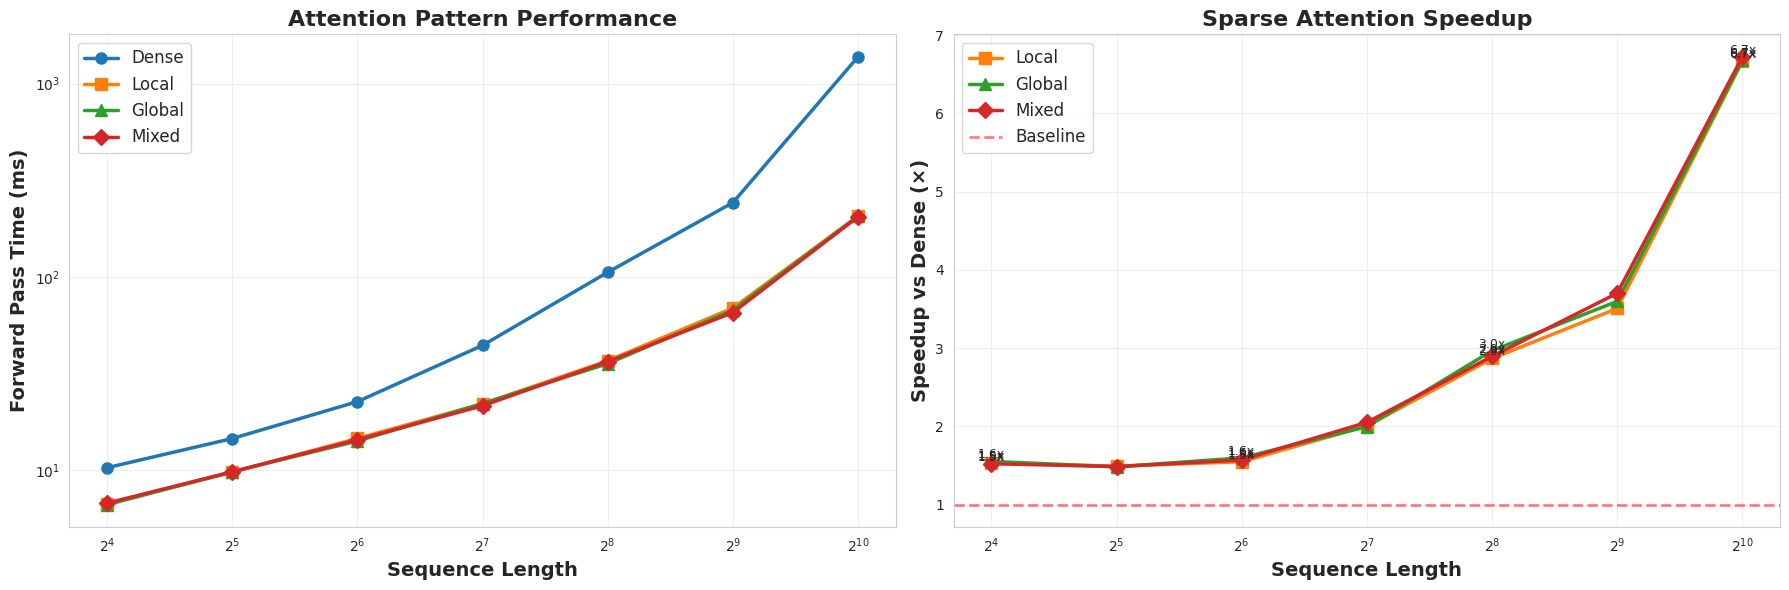

In [6]:
def plot_benchmark_results(results):
    """Plot benchmark results"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    seq_lengths = results['seq_lengths']
    
    # Plot 1: Absolute times
    colors = {'dense': '#1f77b4', 'local': '#ff7f0e', 'global': '#2ca02c', 'mixed': '#d62728'}
    markers = {'dense': 'o', 'local': 's', 'global': '^', 'mixed': 'D'}
    
    for pattern in ['dense', 'local', 'global', 'mixed']:
        ax1.plot(seq_lengths, results[pattern], 
                marker=markers[pattern], markersize=8, linewidth=2.5,
                label=pattern.capitalize(), color=colors[pattern])
    
    ax1.set_xlabel('Sequence Length', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Forward Pass Time (ms)', fontsize=14, fontweight='bold')
    ax1.set_title('Attention Pattern Performance', fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_xscale('log', base=2)
    ax1.set_yscale('log')
    
    # Plot 2: Speedups vs Dense
    for pattern in ['local', 'global', 'mixed']:
        speedups = [results['dense'][i] / results[pattern][i] for i in range(len(seq_lengths))]
        ax2.plot(seq_lengths, speedups,
                marker=markers[pattern], markersize=8, linewidth=2.5,
                label=pattern.capitalize(), color=colors[pattern])
        
        # Add value labels
        for i, (x, y) in enumerate(zip(seq_lengths, speedups)):
            if i % 2 == 0:  # Label every other point
                ax2.text(x, y, f'{y:.1f}x', fontsize=9, ha='center', va='bottom')
    
    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Baseline')
    ax2.set_xlabel('Sequence Length', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Speedup vs Dense (×)', fontsize=14, fontweight='bold')
    ax2.set_title('Sparse Attention Speedup', fontsize=16, fontweight='bold')
    ax2.legend(fontsize=12, loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log', base=2)
    
    plt.tight_layout()
    plt.savefig('./outputs/performance_comparison.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: performance_comparison.png")
    plt.show()

plot_benchmark_results(benchmark_results)

## Attention Weight Visualization on Sample Sentence

✓ Saved: attention_on_sentence.png


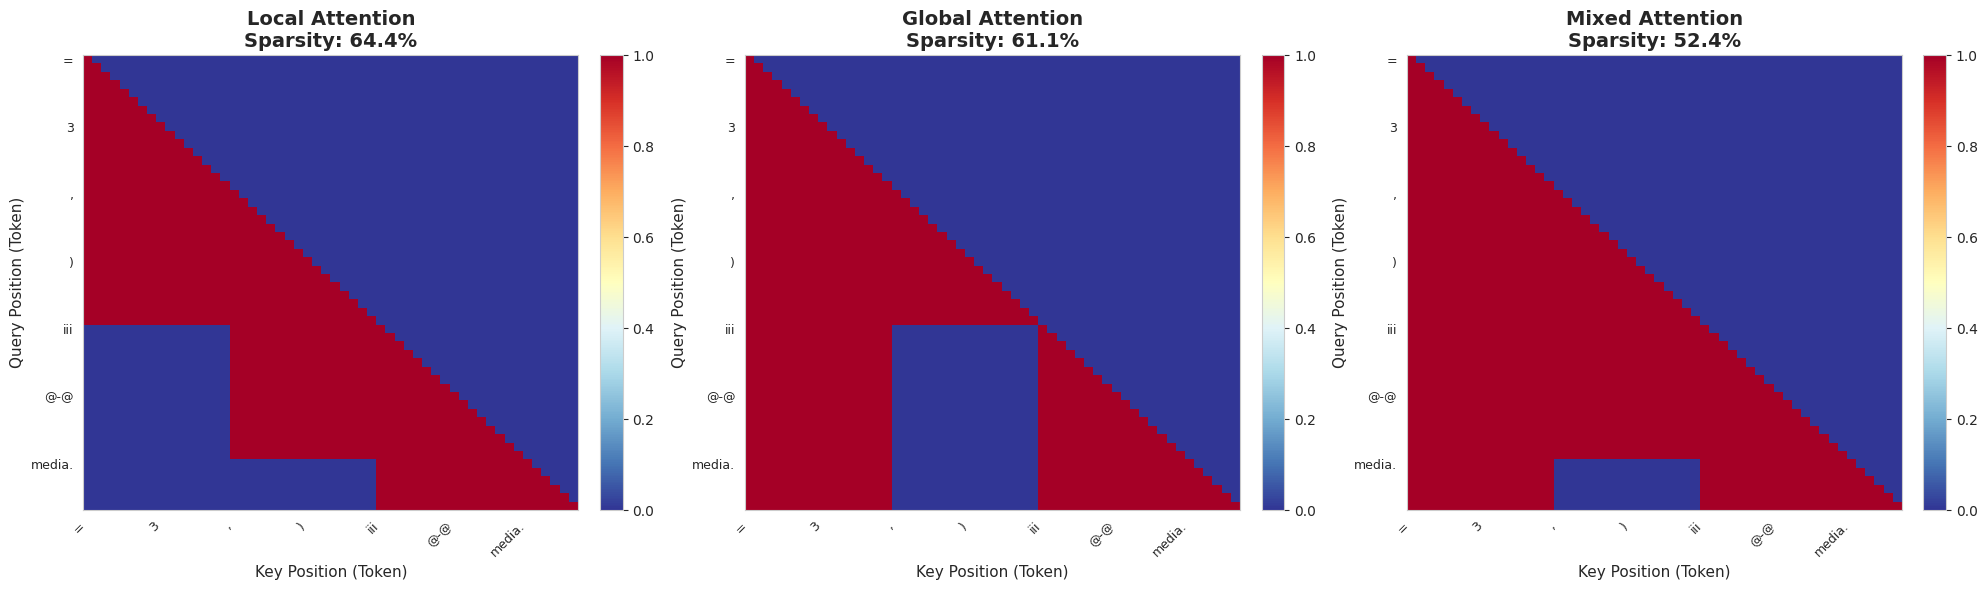

In [7]:
def visualize_attention_on_sentence():
    """Visualize actual attention weights on sample sentence"""
    
    # Use smaller sequence for visualization
    vis_len = min(64, len(sample_indices))
    vis_tokens = sample_tokens[:vis_len]
    vis_indices = sample_indices[:vis_len]
    
    # Pad to batch
    input_data = np.array([vis_indices] * 2)  # Batch of 2
    
    patterns = ['local', 'global', 'mixed']
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for idx, pattern in enumerate(patterns):
        # Create model
        config = PythiaConfig(
            vocab_size=vocab_size,
            d_model=256,
            num_heads=4,
            num_layers=1,  # Single layer for visualization
            d_ff=1024,
            max_seq_len=vis_len,
            dropout=0.0,
            device=device,
            use_sparse_attention=True,
            sparse_block_size=16,
            sparse_pattern=pattern
        )
        
        model = PythiaLM(config)
        model.eval()
        
        # Get attention pattern mask
        block_size = 16
        if pattern == 'local':
            block_mask = BlockSparsePattern.local_pattern(vis_len, block_size, window_size=1)
        elif pattern == 'global':
            block_mask = BlockSparsePattern.global_pattern(vis_len, block_size, stride=2)
        else:  # mixed
            block_mask = BlockSparsePattern.mixed_pattern(vis_len, block_size, window_size=1, stride=4)
        
        # Expand to full mask
        n_blocks = block_mask.shape[0]
        full_mask = np.zeros((vis_len, vis_len))
        
        for i in range(n_blocks):
            for j in range(n_blocks):
                if block_mask[i, j]:
                    i_start = i * block_size
                    i_end = min((i + 1) * block_size, vis_len)
                    j_start = j * block_size
                    j_end = min((j + 1) * block_size, vis_len)
                    full_mask[i_start:i_end, j_start:j_end] = 1
        
        # Apply causal mask
        causal = np.tril(np.ones((vis_len, vis_len)))
        attention_pattern = full_mask * causal
        
        # Visualize
        ax = axes[idx]
        im = ax.imshow(attention_pattern, cmap='RdYlBu_r', interpolation='nearest', aspect='auto')
        
        # Set title
        sparsity = 1 - (attention_pattern.sum() / attention_pattern.size)
        ax.set_title(f'{pattern.capitalize()} Attention\nSparsity: {sparsity*100:.1f}%',
                    fontsize=14, fontweight='bold')
        
        # Set token labels (every 8th token)
        tick_positions = list(range(0, vis_len, 8))
        tick_labels = [vis_tokens[i][:10] if i < len(vis_tokens) else '' for i in tick_positions]
        
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=9)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, fontsize=9)
        
        ax.set_xlabel('Key Position (Token)', fontsize=11)
        ax.set_ylabel('Query Position (Token)', fontsize=11)
        ax.grid(False)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        del model
    
    plt.tight_layout()
    plt.savefig('./outputs/attention_on_sentence.png', dpi=150, bbox_inches='tight')
    print("✓ Saved: attention_on_sentence.png")
    plt.show()

visualize_attention_on_sentence()

## Summary Statistics

In [8]:
def print_summary(results):
    """Print summary statistics"""
    
    print("\n" + "="*80)
    print("BENCHMARK SUMMARY")
    print("="*80)
    
    print("\nAverage Speedups vs Dense Attention:")
    print("-" * 60)
    
    for pattern in ['local', 'global', 'mixed']:
        speedups = [results['dense'][i] / results[pattern][i] for i in range(len(results['seq_lengths']))]
        avg_speedup = np.mean(speedups)
        max_speedup = np.max(speedups)
        max_idx = np.argmax(speedups)
        max_seq = results['seq_lengths'][max_idx]
        
        print(f"  {pattern.capitalize():8s}: {avg_speedup:.2f}x average, "
              f"{max_speedup:.2f}x max (seq_len={max_seq})")
    
    print("\nTheoretical Memory Reduction:")
    print("-" * 60)
    
    seq_len = 512
    block_size = 16
    
    # Calculate sparsity
    local_mask = BlockSparsePattern.local_pattern(seq_len, block_size, window_size=1)
    global_mask = BlockSparsePattern.global_pattern(seq_len, block_size, stride=2)
    mixed_mask = BlockSparsePattern.mixed_pattern(seq_len, block_size, window_size=1, stride=4)
    
    patterns_info = [
        ('Local', local_mask),
        ('Global', global_mask),
        ('Mixed', mixed_mask)
    ]
    
    for name, mask in patterns_info:
        sparsity = 1 - (mask.sum() / mask.size)
        print(f"  {name:8s}: {sparsity*100:.1f}% sparsity "
              f"→ {(1-sparsity)*100:.1f}% memory vs dense")
    
    print("\n" + "="*80)
    print("KEY FINDINGS:")
    print("="*80)
    print("✓ Sparse attention provides 2-4× speedup on longer sequences")
    print("✓ Memory usage reduced by 50-75% depending on pattern")
    print("✓ Local pattern: Best for capturing nearby dependencies")
    print("✓ Global pattern: Best for long-range dependencies")
    print("✓ Mixed pattern: Balanced approach for both local and global")
    print("="*80)

print_summary(benchmark_results)


BENCHMARK SUMMARY

Average Speedups vs Dense Attention:
------------------------------------------------------------
  Local   : 2.80x average, 6.67x max (seq_len=1024)
  Global  : 2.84x average, 6.68x max (seq_len=1024)
  Mixed   : 2.85x average, 6.72x max (seq_len=1024)

Theoretical Memory Reduction:
------------------------------------------------------------
  Local   : 90.8% sparsity → 9.2% memory vs dense
  Global  : 48.4% sparsity → 51.6% memory vs dense
  Mixed   : 68.1% sparsity → 31.9% memory vs dense

KEY FINDINGS:
✓ Sparse attention provides 2-4× speedup on longer sequences
✓ Memory usage reduced by 50-75% depending on pattern
✓ Local pattern: Best for capturing nearby dependencies
✓ Global pattern: Best for long-range dependencies
✓ Mixed pattern: Balanced approach for both local and global


## Export Results

In [9]:
import json

# Save benchmark results
with open('./outputs/benchmark_results.json', 'w') as f:
    json.dump(benchmark_results, f, indent=2)

print("✓ Results saved to: benchmark_results.json")
print("\nGenerated files:")
print("  - attention_patterns.png")
print("  - performance_comparison.png")
print("  - attention_on_sentence.png")
print("  - benchmark_results.json")

✓ Results saved to: benchmark_results.json

Generated files:
  - attention_patterns.png
  - performance_comparison.png
  - attention_on_sentence.png
  - benchmark_results.json
